In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pt

data = pd.read_csv('C:/Users/Andrew/Downloads/bandwidth.csv')
data.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


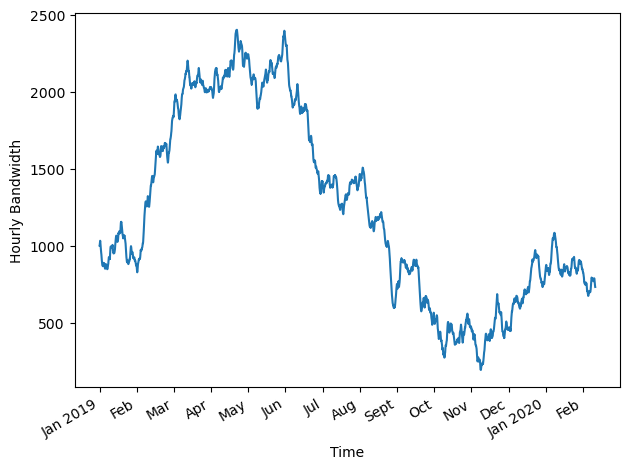

In [3]:
fig, ax = pt.subplots()

ax.plot(data['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly Bandwidth')
pt.xticks(np.arange(0, 10000, 750), 
         ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])
fig.autofmt_xdate()
pt.tight_layout()

In [4]:
from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(42)
ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [5]:
from statsmodels.tsa.stattools import adfuller

ADF_results = adfuller(ARMA_1_1)
print(f'ADF Statistics: {ADF_results[0]}')
print(f'P-value: {ADF_results[1]}')

ADF Statistics: -6.42987868204268
P-value: 1.7078466680097942e-08


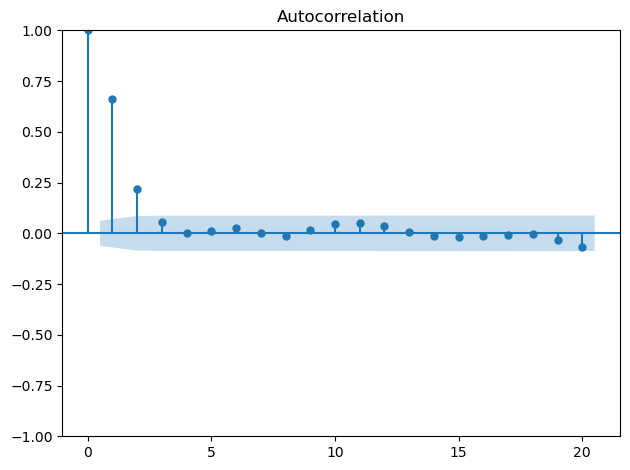

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ARMA_1_1, lags=20)
pt.tight_layout()

C:\Users\Andrew\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


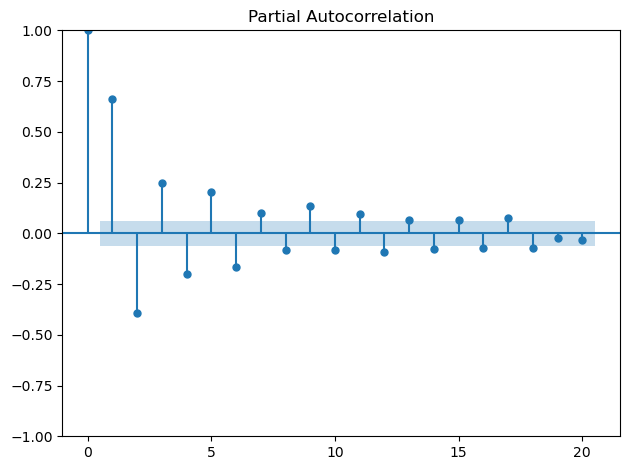

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ARMA_1_1, lags=20)
pt.tight_layout()

# Devising a general modeling procedure

As per above, we saw that if both the ACF and PACF plots display a sinusoidal or decaying pattern, our time series can be modeled by an ARMA(p,q) process. However, neither plot was useful for determining the orders p and q. Without simulated ARMA(1,1) process, we noticed that coefficients were significant after lag 1 in both plots. Thus, we must devise a procedure that allows us to find orders p and q. This procedure will have the advantage that it can also be applied in situations where our time series is non-stationary and has seasonal effects.

The first few steps remain unchanged from those we gradually built up like MA and AR process. We must still gather data, test for stationarity, and apply transformations accordingly. Then we list different possible values for p and q (note that they only take positive integers). With a list of possible values, we can fit every unique combination of ARMA(p,q) to our data.

Once that is done, we can compute the Akaike Information Criterion (AIC), which is a technique to select the optimal model. It quantifies the quality of each moedl in relation to each other and the model with the lowest AIC is then selected. From there, we can analyze the model's residuals, which is the difference between the actual and predicted values of the model. Ideally, the residuals will look like white noise, which would mean that any difference between the predicted values and actual values is due to randomness. Therefore, the residuals must be uncorrelated and independently distributed. We can assess those properties by studying the quantile-quantile plot (Q-Q plot) and running the Ljung-Box test. If the analysis leads us to conclude that the residuals are completely random, we have a model ready for forecasting. Otherwise, we must try a different set of values for p and q and start over the process.

In [8]:
from itertools import product

ps = range(0,4,1) #Create a list of possible values for p starting from 0 inclusively to 4 exclusively, with steps of 1
qs = range(0,4,1) #Create a list of possible values of q starting from 0 inclusively to 4 exclusively, with steps of 1


order_list = list(product(ps, qs))

In [9]:
#Function to fit all unique ARMA(p,q) models
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    #Initialize an empty list to store the order (p,q) and its corresponding AIC as a tuple
    results = [] 
    
    #Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar.
    for order in tqdm_notebook(order_list): 
        try:
            #simple_differencing = False to prevent differencing
            #disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, order=(order[0], 0, order[1]),
                            simple_differencing = False).fit(disp=False)
        except:
            continue
        
        aic = model.aic #Calculate the model's AIC
        results.append([order,aic]) #Append the (p,q) combination and AIC as a tuple to result list
    
    result_data = pd.DataFrame(results) #Store the combination in a DataFrame
    result_data.columns = ['(p,q)', 'AIC'] #Label the columns of the DataFrame
    
    #Sort in ascending order, lower AIC is better
    result_data = result_data.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_data

In [10]:
result_data = optimize_ARMA(ARMA_1_1, order_list)
result_data

C:\Users\Andrew\AppData\Local\Temp\ipykernel_18500\1216436277.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\Andrew\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Andrew\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Andrew\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(2, 3)",2806.175380
8,"(3, 3)",2806.291253
9,"(3, 2)",2806.894930


As we can see from the AIC, we can say that an ARMA(1,1) model is the best model relative to all other models that we fit to our data because it has the lowest AIC. Now we need an absoluate measure of the model's quality. This bring us o the next step of our modeling process, which is residual analysis.

# Understanding Residual Analysis

This is the last step before forecasting, which is residual analysis and answering the two questions in the flowchart: does the Q-Q plot show a straight line, and are the residuals uncorrelated? If the answer to both questions is yes, then we have a model that is ready to make forecasts. Otherwise, we must try different combinations of (p,q) and restart the process.

The residuals of a model are simply the difference between the predicted values and the actual values. For example, consider our simulated ARMA(1,1) expressed as: 

                       yt = 0.33yt + 0.9et-1 + et
                       
And suppose that we fit an ARMA(1,1) model to our process and we estimate the model's coefficient perfecly, such that the model is express as:
                             
                       yhat = 0.33yt-1 + 0.9et-1
                       
The residuals will be the difference between the values coming from our model and the observed values from our simulated process.

                residuals = 0.33yt-1 + 0.9et-1 + et - (0.33yt-1 + 0.9)
                residuals = et
                
In perfect situations, the residuals of a model are white noise. This indicates that the model has captured all predictive information, and there is only a random fluctuation left that cannot be modeled. Thus, the residuals must be uncorrelated and have a normal distribution in order for us to conclude that we have a good model for making forecasts

There are two aspect to residual analysis: 

- Qualitative Analysis: focuses on studying the Q-Q plot
- Quantitative Analysis: determines whether our residuals are uncorrelated

# Qualitative Analysis
# Quantile-Quantile plot (Q-Q plot) 

The Q-Q plot is a plot of the quantiles of two distributions against each other. In time series forecasting, we plot the distribution of our residuals on the y-axis against the theoretical normal distribution on the x-axis.

This graphical tool allows us to assess the goodness of fit of our model. If the distribution of our residuals is similar to a normal distribution, we will see a straight line lying on y=x. This means that our model is a good fit, becaues the residuals are similar to white noise. 

On the other hand, if the distribution of our residuals is different from a normal distribution, we will see a curved line. We can then conclude that our model is not a good fit, since the residuals' distribution is not as close to a normal distribution, and therefore the residuals are not similar to white noise. 

# Quantitative Analysis 
# Ljung-Box Test

The Ljung-Box test is a statistical test that determines whether the autocorrelation of a group of data is significantly different from 0

In time series forecasting, we apply the Ljung-Box test on the model's residuals to test whether they are similar to white noise. The null hypothesis states that the data is independently distributed, meaning that there is no autocorrelation. If the p-value is larger than 0.05, we cannot reject the null hypothesis, meaning that the residuals are independently distributed. Therefore, there is no autocorrelation, the residuals are similar to white noise, and the model can used for forecasting. 

If the p-value is less than 0.05, we reject the null hypothesis, meaning that our residuals are not independently distributed and are correlated. The model cannot be used for forecasting.

The Ljung-Box test will return a Ljung-Box statistic and a p-value. 

# Performing Residual Analysis

In [11]:
#order = (p, d, q) 
#d = differencing, since we are not doing any differencing, it is 0
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid #Store the model's residuals

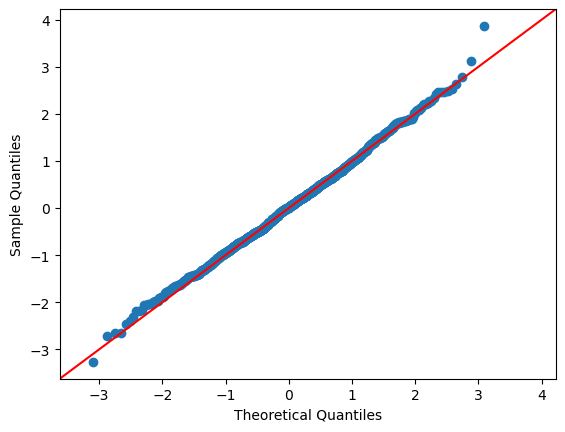

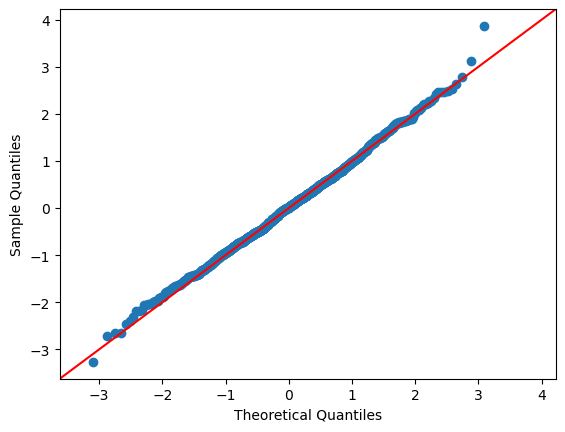

In [12]:
#Plotting the Q-Q plot
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45') #plot the Q-Q plot of the residuals. Specify the display of the line y=x

Q-Q Plot of our ARMA(1,1) residuals. You can see a thick straight line lying on y=x. This means that our residuals are normally distributed, just like white noise.

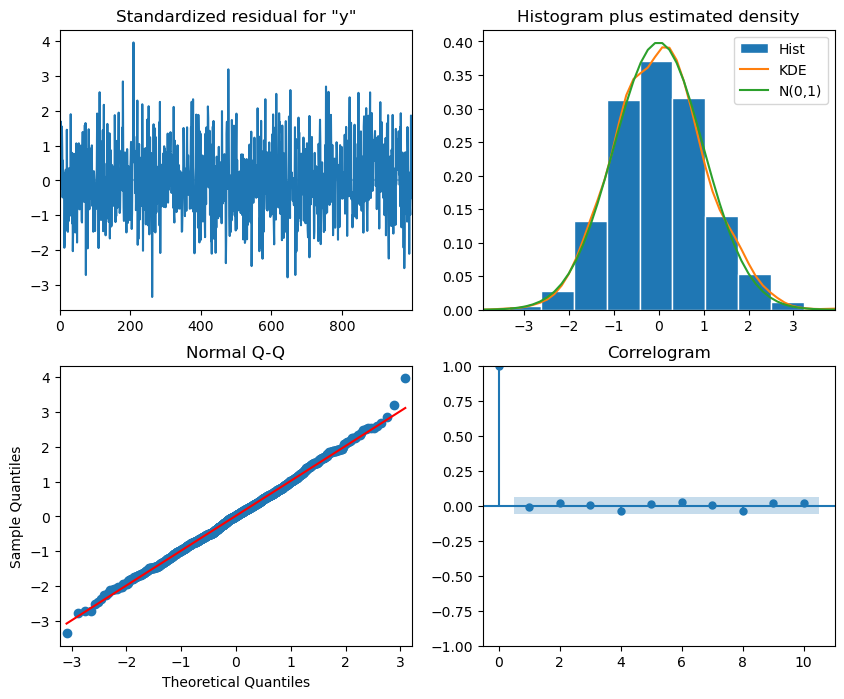

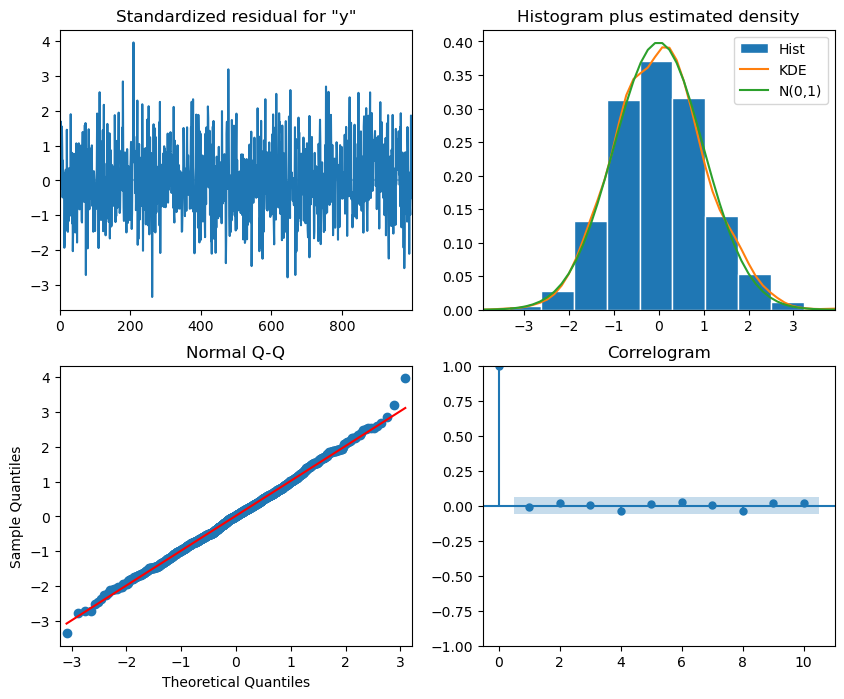

In [13]:
model_fit.plot_diagnostics(figsize=(10,8))

The top left (Standardized resdual for 'y') shows the residuals across the entire dataset. You can see there is no trend, and the mean seems stable over time, which is indicative of stationarity, just like white noise.

The top right (Histogram plus estimated density) shows a histogram of the residuals. You can see the shape of a normal distribution on this plot, which again indicates that the residuals are close to white noise, as white noise is normally distributed as well.

At the bottom left, we have the Q-Q plot, which is the same as the Q-Q plot above.

At the bottom right (Correlogram), shows the autocorreltaion function of our residuals. You can see there is only a significant peak at lag 0, and no significant coefficients otherwise. This means that the residuals are not correlated, which further supports the conclusion that they are similar to white noise, which is what we expect from a good model.

The final step of residual analysis is applying the Ljung-Box test on the residuals. The function takes the residuals as input as well as list of lags. Here we will compute the Ljung-Box statistic and p-value for 10 lags.

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#Apply the Ljung-Box test on the residuals, on 10 lags
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


Apparently, the output has bugged but all 10 lags p-values are more than 0.05.  Which mean we cannot reject the null hypothesis for each lag and that the residuals are independently distributed and there is not correlation.

We can conclude that from our analysis that the residuals are similar to white noise. The Q-Q plot showed a straight line, meaning that the residuals are normally distributed. Furthermore, the Ljung-Box test shows that the residuals are uncorrelated, just like white noise. Thus, the residuals are completely random, meaning that we have a model that fits our data well.

Now, let's apply the same modeling procedure to the bandwidth dataset.